In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

Funzione per la discesa del gradiente
- alpha => learning rate
- tolerance => ciò che ci permette di fermarci quando non ci sono più miglioramenti significativi nella funzione di costo
- theta => parametri da apprendere
- x => features
- y => target
- m => numero di esempi

In [5]:
def gradientDescent(alpha, tolerance, theta, x, y, m):
    step=1
    previousCost = 1000000000000000
    while True:
        h = np.dot(x, theta) #ipotesi, ovvero i valori predetti
        #Discesa del gradiente
        theta = theta - ((alpha * (1/m)) * np.dot((h - y).T, x).T)
        j_cost = (np.sum((h - y)**2))/(2*m)
        diff = previousCost - j_cost
        if diff < tolerance:
            break
        else:
            #aggiornamento costo & incremento step
            previousCost = j_cost
            step=step+1

    return theta

Funzione per calcolare le predizioni
- x_test => features del test set
- theta => parametri derivanti dalla fase di training

In [6]:
def predictions(x_test, theta):
    pred = np.dot(x_test, theta)
    return pred

Funzione per la valutazione
- prediction => predizioni del modello
- target => target del dataset

In [7]:
def modelEvaluation(prediction, target):
    meanTarget = np.mean(target)

    #R2
    sse = np.sum((prediction-target)**2)
    sst = np.sum((target - meanTarget)**2)
    r2 = 1- (sse/sst)

    #Mean absolute error
    mae = np.mean(np.abs(prediction - target))

    #RMSE
    rmse = np.sqrt((np.sum((prediction - target)**2)) / len(prediction))

    return (r2, rmse)

Funzioni di stampa dei risultati

In [8]:
def printLinRegFunction(theta, data):
    print("########## MODELLO ##########")
    print('\n' + data.columns.values[len(theta)] + " = ")
    for i in range(len(theta)):
        print('\t' + str(round(theta[i], 5)) + ' * ' + data.columns.values[i] + ' +')


def printEvaluationResults(r2, rmse):
    print('\n########## RISULTATI VALUTAZIONE ##########')
    print('\nR2 = ' + str(round(r2, 5)))
    print('Root Mean Squared Error = ' + str(round(rmse, 5)))

### Carico il dataset

In [9]:
dataset = pd.read_csv('cars_numeric.csv')

# è meglio mischaire le righe del dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)

# bisogna inserire la colonna di bias
dataset.insert(0, 'bias', np.ones(dataset.shape[0]), True)

### Valutazione tramite split 70/30

In [10]:
training_set = dataset.head(round(len(dataset)*(70/100)))
test_set = dataset.tail(len(dataset) - len(training_set)).reset_index(drop=True)

#fase di fit
alpha = 0.1
tolerance = 0.000001
x = training_set.drop('price', axis = 1).values
y = training_set['price'].values
m = len(training_set)

#inizializzazione dei theta
# genero un array di theta casuali inizializzati in base ai valori massimi e minimi dei dati 
# target (y) e in base al numero di features nella matrice delle features (x)
theta = np.random.uniform(-(np.max(y)), np.max(y), size=x.shape[1])

finalTheta = gradientDescent(alpha=alpha, tolerance=tolerance, theta=theta, x=x, y=y, m=m)


#Valutazione
x_test = test_set.drop('price', axis = 1).values
predizione = predictions(x_test, finalTheta)
y_dataset = test_set['price'].values

r2, rmse = modelEvaluation(prediction=predizione, target=y_dataset)

### Stampe & grafici

In [11]:
print("VALUTAZIONE DEL MODELLO TRAMITE SPLIT 70/30")
printLinRegFunction(theta=finalTheta, data=dataset)
printEvaluationResults(r2=r2, rmse=rmse)

VALUTAZIONE DEL MODELLO TRAMITE SPLIT 70/30
########## MODELLO ##########

price = 
	13111.95989 * bias +
	-59.26408 * symboling +
	-254.9988 * normalized-losses +
	-1089.75987 * make +
	-1759.72812 * fuel-type +
	1152.14331 * aspiration +
	346.395 * num-of-doors +
	-347.23403 * body-style +
	-470.59522 * drive-wheels +
	2038.56699 * engine-location +
	243.27637 * wheel-base +
	342.00079 * length +
	204.31659 * width +
	314.30739 * height +
	2408.97395 * curb-weight +
	-435.25289 * engine-type +
	1703.24481 * num-of-cylinders +
	2678.01353 * engine-size +
	-615.24068 * fuel-system +
	-32.20501 * bore +
	-645.2036 * stroke +
	1989.38056 * compression-ratio +
	37.80741 * horsepower +
	276.72466 * peak-rpm +
	-993.91701 * city-mpg +
	1272.68403 * highway-mpg +

########## RISULTATI VALUTAZIONE ##########

R2 = 0.84003
Root Mean Squared Error = 3619.31803


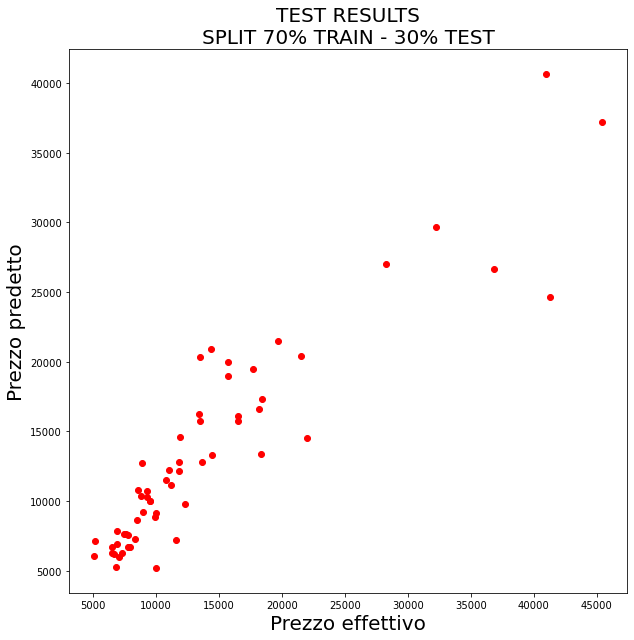

In [12]:
plt.figure(figsize=(10,10))
plt.scatter(x = y_dataset, y = predizione, c='red') 
plt.title("TEST RESULTS\nSPLIT 70% TRAIN - 30% TEST", fontsize=20)
plt.xlabel("Prezzo effettivo", fontsize=20)
plt.ylabel("Prezzo predetto", fontsize=20)
plt.show()

### Cross validazione

Funzione per la cross validazione

In [13]:
def crossValidation(alpha, tolerance, n_folds, dataset):
    foldDimension = dataset.shape[0] // n_folds
    finalTheta = 0
    bestRMSE = 0
    somma_r2 = 0
    somma_rmse = 0

    for i in range(n_folds):
        startFold = i * foldDimension
        endFold = (i+1) * foldDimension

        # per il training set "tolgo" i fold fra startFold e endFold
        # training_set è un nuovo dataframe con le righe indicate dall'intervallo [startFold : endFold] eliminate e con un nuovo indice sequenziale
        training_set = dataset.drop(dataset.index[startFold : endFold]).reset_index(drop = True)
        x_training = training_set.drop('price', axis = 1).values
        y_training = training_set['price'].values

        # uso i fold tolti per il test set
        test_set = dataset[startFold : endFold].reset_index(drop = True)
        x_test = test_set.drop('price', axis = 1).values
        y_test = test_set['price'].values

        m = len(training_set)

        # genero un array di theta casuali inizializzati in base ai valori massimi e minimi dei dati 
        # target (y_training) e in base al numero di features nella matrice delle features (x_training)
        theta = np.random.uniform(-(np.max(y_training)), np.max(y_training), size=x_training.shape[1])
        thetaTrain = gradientDescent(alpha, tolerance, theta, x_training, y_training, m)

        prediction = predictions(x_test=x_test, theta=thetaTrain)

        r2, rmse = modelEvaluation(prediction=prediction, target=y_test)

        if i == 0:
            finalTheta = thetaTrain
            bestRMSE = rmse
        elif rmse < bestRMSE:
            finalTheta = thetaTrain
            bestRMSE = rmse

        somma_r2 = somma_r2 + r2
        somma_rmse = somma_rmse + rmse

    # dividendo le somme per nfolds si ottiene una media delle misure di valutazione su tutti i fold, 
    # rende le stime più rappresentative delle prestazioni del modello sull'intero dataset
    sum_r2_mean = somma_r2/n_folds
    sum_rmse_mean = somma_rmse/n_folds

    return finalTheta, sum_r2_mean, sum_rmse_mean

altra versione della corss validazione (da testare)

In [14]:
def crossValidationV2(alpha, tolerance, n_folds, dataset):
    foldDimension = dataset.shape[0] // n_folds
    finalTheta = None
    bestRMSE = float('inf')
    sum_r2_mean = 0
    sum_rmse_mean = 0

    for i in range(n_folds):
        startFold = i * foldDimension
        endFold = (i + 1) * foldDimension

        training_set = dataset.drop(index=range(startFold, endFold)).reset_index(drop=True)
        x_training = training_set.drop('price', axis=1).values
        y_training = training_set['price'].values

        test_set = dataset.loc[startFold:endFold-1].reset_index(drop=True)
        x_test = test_set.drop('price', axis=1).values
        y_test = test_set['price'].values

        m = len(training_set)
        theta = np.random.uniform(-np.max(y_training), np.max(y_training), size=x_training.shape[1])
        thetaTrain = gradientDescent(alpha, tolerance, theta, x_training, y_training, m)

        prediction = predictions(x_test, thetaTrain)
        r2, rmse = modelEvaluation(prediction, y_test)

        if rmse < bestRMSE:
            bestRMSE = rmse
            finalTheta = thetaTrain

        sum_r2_mean += r2
        sum_rmse_mean += rmse

    avg_r2 = sum_r2_mean / n_folds
    avg_rmse = sum_rmse_mean / n_folds

    return finalTheta, avg_r2, avg_rmse


### Test con cross validazione

Carico il dataset

In [15]:
dataset = pd.read_csv('cars_numeric.csv')

# è meglio mischaire le righe del dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)

# bisogna inserire la colonna di bias
dataset.insert(0, 'bias', np.ones(dataset.shape[0]), True)

In [16]:
print('\n******* TEST CON CROSS-VALIDAZIONE *******')
alpha = 0.01
tolerance = 0.00000001
(finalTheta, r2, rmse) = crossValidation(alpha, tolerance, 10, dataset)

printLinRegFunction(theta=finalTheta, data=dataset)
printEvaluationResults(r2=r2, rmse=rmse)


******* TEST CON CROSS-VALIDAZIONE *******
########## MODELLO ##########

price = 
	13257.21583 * bias +
	115.43168 * symboling +
	-316.96609 * normalized-losses +
	-1028.10941 * make +
	1265.17979 * fuel-type +
	778.39055 * aspiration +
	-39.0713 * num-of-doors +
	-339.63623 * body-style +
	-615.05328 * drive-wheels +
	1607.91802 * engine-location +
	400.36655 * wheel-base +
	129.00766 * length +
	909.25436 * width +
	447.86498 * height +
	1563.21603 * curb-weight +
	-2.84872 * engine-type +
	1367.33419 * num-of-cylinders +
	3748.08583 * engine-size +
	-696.50809 * fuel-system +
	2.76156 * bore +
	-738.04585 * stroke +
	-620.91526 * compression-ratio +
	1.34858 * horsepower +
	748.32158 * peak-rpm +
	-1489.342 * city-mpg +
	1877.58312 * highway-mpg +

########## RISULTATI VALUTAZIONE ##########

R2 = 0.83889
Root Mean Squared Error = 2832.44931
